# ABR analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from usnm2p.fileops import get_data_root, get_figdir
from usnm2p.logger import logger
from usnm2p.postpro import free_expand
from usnm2p.abr_utils import *
from usnm2p.constants import *
from usnm2p.plotters import harmonize_axes_limits

### Input/output directories

In [3]:
dataroot = get_data_root(kind='ABR')
figsroot = get_data_root(kind=DataRoot.FIG)

### Parameters

In [4]:
ABR_tbounds = (0.19, 0.26)  # bounds of ABR response window (s)

### Load input data

In [5]:

# # List input data files
# datadir = os.path.join(dataroot, 'SST130_predeafening')
# ABF_files = [f for f in os.listdir(datadir) if f.endswith('.abf')]
# ABF_fpaths = [os.path.join(datadir, f) for f in ABF_files]
# logger.info(f'found {len(ABF_files)} ABF files in {datadir}')

# Dictionary of ABF files to analyze
ABF_fnames = {
    'pre-deafening, left ear, 16kHz, 90dB': 'SST130_predeafening/20304003.abf',
    'pre-deafening, right ear, 16kHz, 90dB': 'SST130_predeafening/20304007.abf',
    'post-deafening, left ear, 16kHz, 90dB': 'SST130_postdeafening/20316005.abf',
    'post-deafening, left ear, 8kHz, 90dB': 'SST130_postdeafening/20316006.abf',
    'post-deafening, right_ear, 16kHz, 90dB': 'SST130_postdeafening/20316003.abf',
    'post-deafening, right ear, 8kHz, 90dB': 'SST130_postdeafening/20316004.abf',
}
ABF_fpaths = {k: os.path.join(dataroot, v) for k, v in ABF_fnames.items()}

# Load ABR data
data = pd.concat({k: load_abr_data(v) for k, v in ABF_fpaths.items()}, axis=0, names=['dataset'])

# Select ABR window subset
data = data.loc[(data[Label.TIME] >= ABR_tbounds[0]) & (data[Label.TIME] <= ABR_tbounds[1])]

# Split 'dataset' index into meaningful columns
logger.info('extracting information from "dataset" index')
datasets = data.index.unique('dataset')
splits = datasets.str.split(', ').str
keys = ['condition', 'ear', 'frequency', 'intensity']
info = pd.DataFrame({k: split for k, split in zip(keys, splits)}, index=datasets)
exp_info = free_expand(info, data)

# Add 'info' columns to data index
data = pd.concat([data, exp_info], axis=1)
for k in keys:
    logger.info(f'adding {k} information to data index')
    data = data.set_index(k, append=True)
data = data.reorder_levels(['dataset', *keys, 'sweep', 'sample'])

# Extract sampling rate
dt = data[Label.TIME].iloc[:2].diff().iloc[-1]  # s
sr = np.round(1 / dt)  # Hz
logger.info(f'sampling rate: {sr} Hz')

# Show data
data

 2024/08/22 17:13:38: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_predeafening/20304003.abf ABF file
 2024/08/22 17:13:38: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_predeafening/20304007.abf ABF file
 2024/08/22 17:13:38: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_postdeafening/20316005.abf ABF file
 2024/08/22 17:13:39: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_postdeafening/20316006.abf ABF file
 2024/08/22 17:13:39: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_postdeafening/20316003.abf ABF file
 2024/08/22 17:13:39: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130_postdeafening/20316004.abf ABF file
 2024/08/22 17:13:41: extracting information from "dataset" index
 2024/08/22 17:13:42: expanding (6 datasets) input dataframe to match (6 datasets x 512 sweeps x 1401 samples) reference dataframe
 2024/08/22 17:13:52: adding condition information to data index
 2024/08/22 17:13:53: adding ear information to data index
 20

time (s)  \
dataset                               condition      ear       frequency intensity sweep sample             
pre-deafening, left ear, 16kHz, 90dB  pre-deafening  left ear  16kHz     90dB      0     3800     0.19000   
                                                                                         3801     0.19005   
                                                                                         3802     0.19010   
                                                                                         3803     0.19015   
                                                                                         3804     0.19020   
...                                                                                                   ...   
post-deafening, right ear, 8kHz, 90dB post-deafening right ear 8kHz      90dB      511   5196     0.25980   
                                                                                         5197     0.25985   
                                                                                         5198     0.25990   
                                                                                         5199     0.25995   
                                                                                         5200     0.26000   

                                                                                                 stim (mV)  \
dataset                               condition      ear       frequency intensity sweep sample              
pre-deafening, left ear, 16kHz, 90dB  pre-deafening  left ear  16kHz     90dB      0     3800    16.784668   
                                                                                         3801    16.174316   
                                                                                         3802    14.648438   
                                                                                         3803    14.953613   
                                                                                         3804    11.596680   
...                                                                                                    ...   
post-deafening, right ear, 8kHz, 90dB post-deafening right ear 8kHz      90dB      511   5196    17.089844   
                                                                                         5197    16.479492   
                                                                                         5198    18.310547   
                                                                                         5199    13.122559   
                                                                                         5200    11.901855   

                                                                                                  ABR (mV)  
dataset                               condition      ear       frequency intensity sweep sample             
pre-deafening, left ear, 16kHz, 90dB  pre-deafening  left ear  16kHz     90dB      0     3800    -0.610352  
                                                                                         3801    -5.187988  
                                                                                         3802    -8.239746  
                                                                                         3803    -6.408691  
                                                                                         3804    -7.324219  
...                                                                                                    ...  
post-deafening, right ear, 8kHz, 90dB post-deafening right ear 8kHz      90dB      511   5196   -13.427734  
                                                                                         5197   -20.141602  
                                                                                         5198   -17.395020  
                                                 

### Optional: correct frequency column based on FFT analysis 

In [6]:
# Extract stimulus frequencies directly from stimulus waveforms
logger.info('extracting stimulus frequencies directly from stimulus waveforms')
stimfreqs = (data['stim (mV)']
    .groupby('dataset')
    .agg(lambda x: extract_stim_frequency(x, dt))
    .apply(lambda x: f'{x * 1e-3:.0f}kHz')
    .rename('frequency')
)

# # Override existing 'frequency' index level
# exp_stimfreqs = free_expand(stimfreqs, data)
# logger.info('overriding existing "frequency" index level')
# # data.index.set_levels(exp_stimfreqs, level='frequency')

 2024/08/22 17:13:57: extracting stimulus frequencies directly from stimulus waveforms


In [14]:
stimfreqs

dataset
post-deafening, left ear, 16kHz, 90dB     4kHz
post-deafening, left ear, 8kHz, 90dB      8kHz
post-deafening, right ear, 8kHz, 90dB     8kHz
post-deafening, right_ear, 16kHz, 90dB    4kHz
pre-deafening, left ear, 16kHz, 90dB      4kHz
pre-deafening, right ear, 16kHz, 90dB     4kHz
Name: frequency, dtype: object

### Extract stimulus time bounds from the stimulus channel 

In [7]:
# Extract stimulus ON-OFF indexes from stimulus waveforms
stim_ibounds = data['stim (mV)'].groupby('dataset').agg(extract_stim_window)

# Convert to time bounds using reference 'time' vectors
stim_tbounds = pd.Series(
    {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},
    name='stim bounds (s)')
stim_tbounds

/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_87074/292368508.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},


post-deafening, left ear, 16kHz, 90dB      (0.2007, 0.24905)
post-deafening, left ear, 8kHz, 90dB        (0.2007, 0.2491)
post-deafening, right ear, 8kHz, 90dB     (0.20075, 0.24905)
post-deafening, right_ear, 16kHz, 90dB     (0.20075, 0.2491)
pre-deafening, left ear, 16kHz, 90dB       (0.20075, 0.2491)
pre-deafening, right ear, 16kHz, 90dB      (0.2007, 0.24905)
Name: stim bounds (s), dtype: object

### Offset time vectors to align stim onset with 0

In [8]:
# Offset time vectors to align stimulus onset with t=0
data[Label.TIME] = (
    data[Label.TIME]
    .groupby('dataset')
    .transform(lambda x: x - stim_tbounds[x.index[0][0]][0])
)

# Offset stimulus time bounds as well
stim_tbounds = pd.Series(
    {k: tuple([0, v[1] - v[0]]) for k, v in stim_tbounds.items()},
    name=stim_tbounds.name)
stim_tbounds

post-deafening, left ear, 16kHz, 90dB     (0, 0.048350000000000004)
post-deafening, left ear, 8kHz, 90dB                    (0, 0.0484)
post-deafening, right ear, 8kHz, 90dB      (0, 0.04829999999999998)
post-deafening, right_ear, 16kHz, 90dB    (0, 0.048349999999999976)
pre-deafening, left ear, 16kHz, 90dB      (0, 0.048349999999999976)
pre-deafening, right ear, 16kHz, 90dB     (0, 0.048350000000000004)
Name: stim bounds (s), dtype: object

### Plot ABR responses

 2024/08/22 17:14:55: plotting representative stimulus waveform
 2024/08/22 17:14:56: adding inset in the middle of the stimulus waveform
 2024/08/22 17:14:56: plotting ABR waveform for "post-deafening, left ear, 16kHz, 90dB" dataset
 2024/08/22 17:14:58: plotting ABR waveform for "post-deafening, left ear, 8kHz, 90dB" dataset
 2024/08/22 17:15:00: plotting ABR waveform for "post-deafening, right ear, 8kHz, 90dB" dataset
 2024/08/22 17:15:02: plotting ABR waveform for "post-deafening, right_ear, 16kHz, 90dB" dataset
 2024/08/22 17:15:03: plotting ABR waveform for "pre-deafening, left ear, 16kHz, 90dB" dataset
 2024/08/22 17:15:05: plotting ABR waveform for "pre-deafening, right ear, 16kHz, 90dB" dataset


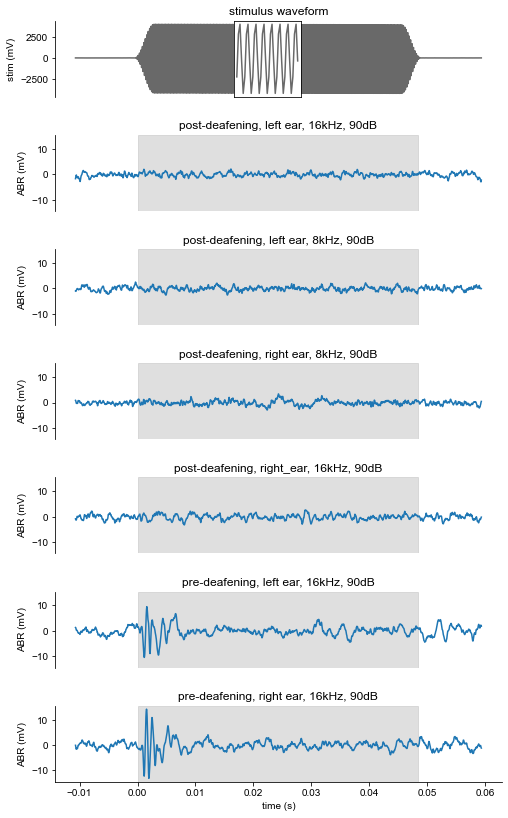

In [12]:
# Create figure
naxes = len(data.index.unique('dataset')) + 1
fig, axes = plt.subplots(naxes, 1, figsize=(8, 2 * naxes))
sns.despine(fig=fig)

# Plot representative stimulus waveform (from first sweep) on first axis
sweepdata = data.loc[tuple(list(data.index[0][:-1]) + [slice(None)])]
logger.info('plotting representative stimulus waveform')
axes[0].set_title('stimulus waveform')
sns.lineplot(
    ax=axes[0], 
    data=sweepdata,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Add inset in the middle of the stimulus waveform
logger.info('adding inset in the middle of the stimulus waveform')
inset_tbounds = np.linspace(*stim_tbounds.iloc[0], 100)[[48, 52]]
inset_data = sweepdata[sweepdata[Label.TIME].between(*inset_tbounds)]
inset_ax = axes[0].inset_axes([0.4, 0, 0.15, 1])
inset_ax.set_xticks([])
inset_ax.set_yticks([])
sns.lineplot(
    ax=inset_ax,
    data=inset_data,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Plot ABR waveforms on subsequent axes
for ax, (dataset, gdata) in zip(axes[1:], data.groupby('dataset')):
    logger.info(f'plotting ABR waveform for "{dataset}" dataset')
    ax.set_title(dataset)
    sns.lineplot(
        ax=ax,
        data=gdata,
        x=Label.TIME,
        y='ABR (mV)',
        errorbar=None,
    )
    ax.axvspan(*stim_tbounds[dataset], color='silver', alpha=0.5)

# Adjust layout
harmonize_axes_limits(axes[1:], 'y')
fig.subplots_adjust(hspace=0.5)
for ax in axes[:-1]:
    sns.despine(ax=ax, bottom=True)
    ax.set_xticks([])
    ax.set_xlabel(None)

### Save figure(s)

In [13]:
fig_fpath = os.path.join(get_figdir(figsroot), 'abr_waveforms.pdf')
logger.info(f'saving figure to {fig_fpath}')
fig.savefig(fig_fpath, bbox_inches='tight')

 2024/08/22 17:15:20: saving figure to /Users/tlemaire/Documents/data/usnm/figs/2024.08.22/abr_waveforms.pdf
